# Vignette 3: Sensitive response to drug perturbation using phosphoproteomics

The aim of this vignette is to explore a new way of evaluating the networks. In this setting, we assume that the networks that better contextualise the perturbation will have a higher average pEC50 in the nodes included in the solution network, compared to the ones not included. On the contrary, the networks which are not able to contextualise the perturbation will not show differences in the EC50 values of the nodes included or excluded.

![Evaluation strategy based on phosphoproteomics sensitivity analysis](../phospho.png)


## 1. Data processing

In [2]:
import networkcommons as nc
import pandas as pd
import decoupler as dc

To showcase this strategy, we will use data from the DecryptM resource, a compendium of 14 different experiments comprising 4 different proteomics profiles and 31 different drugs. 

> Jana Zecha et al., Decrypting drug actions and protein modifications by dose- and time-resolved proteomics. *Science 380,93-101(2023)*. https://doi.org/10.1126/science.ade3925

To see in a nutshell the available experiments from the resource, we can use the following function:


In [3]:
nc.data.omics.decryptm_datasets()

,experiment,data_type,fname
0,10_Kinase_Inhibitors,Phosphoproteome,curves_2KI.txt
1,10_Kinase_Inhibitors,Phosphoproteome,curves_6KI.txt
2,10_Kinase_Inhibitors,Phosphoproteome,curves_Rep.txt
3,3_EGFR_Inhibitors,Fullproteome,curves.txt
4,3_EGFR_Inhibitors,Phosphoproteome,curves.txt
5,BCRABL_Inhibitors,Fullproteome,curves.txt
6,BCRABL_Inhibitors,Phosphoproteome,curves.txt
7,Chemodrugs,Phosphoproteome,curves_Cytarabine.txt
8,Chemodrugs,Phosphoproteome,curves_Methotrexat.txt
9,Chemodrugs,Phosphoproteome,curves_Paclitaxel.txt


For the sake of simplicity, we will focus on one drug targeting EGFR. We get the 3 EGFR inhibitors

In [4]:
decryptm_curves = nc.data.omics.decryptm_table('3_EGFR_Inhibitors', 'Phosphoproteome', 'curves.txt')
decryptm_curves.head()

,Modified sequence,Experiment,N duplicates,Sequence,Length,Missed cleavages,Proteins,Leading proteins,Gene names,Protein names,...,R2,Curve RMSE,Log EC50 error,Curve slope error,Curve top error,Curve bottom error,EC50,pEC50,Curve effect size,Regulation
0,(ac)AAAAAAAGDS(ph)DS(ph)WDADAFSVEDPVRK,ddPTM_A431_Gefitinib_30min_R1,1,AAAAAAAGDSDSWDADAFSVEDPVRK,26,1,O75822-2;O75822;O75822-3,O75822-2,EIF3J,Eukaryotic translation initiation factor 3 sub...,...,0.312473,0.056466,11221.931923,7.936189,871.584121,1158.653028,2.471293e-03,2.607076,2.379040,NaN
1,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,ddPTM_A431_Afatinib_30min_R3,1,AAAAAAAGDSDSWDADAFSVEDPVR,25,0,O75822-2;O75822;O75822-3,O75822-2,EIF3J,Eukaryotic translation initiation factor 3 sub...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVR,ddPTM_A431_Gefitinib_30min_R4,1,AAAAAAAGDSDSWDADAFSVEDPVR,25,0,O75822-2;O75822;O75822-3,O75822-2,EIF3J,Eukaryotic translation initiation factor 3 sub...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVRK,ddPTM_A431_Afatinib_30min_R1,2,AAAAAAAGDSDSWDADAFSVEDPVRK,26,1,O75822-2;O75822;O75822-3,O75822-2,EIF3J,Eukaryotic translation initiation factor 3 sub...,...,0.525850,0.047043,0.167239,3.354840,0.011725,0.014125,3.778167e-08,7.422719,0.119437,NaN
4,(ac)AAAAAAAGDS(ph)DSWDADAFSVEDPVRK,ddPTM_A431_Afatinib_30min_R2,1,AAAAAAAGDSDSWDADAFSVEDPVRK,26,1,O75822-2;O75822;O75822-3,O75822-2,EIF3J,Eukaryotic translation initiation factor 3 sub...,...,0.696323,0.034528,0.558905,0.317307,0.012134,0.058948,3.733359e-07,6.427900,0.189958,NaN


We first filter those fittings with a high R2. We define here an arbitrary threshold of 0.9

In [5]:
filtered_df = decryptm_curves[decryptm_curves['R2']>0.9]

In [6]:
filtered_df.head()

,Modified sequence,Experiment,N duplicates,Sequence,Length,Missed cleavages,Proteins,Leading proteins,Gene names,Protein names,...,R2,Curve RMSE,Log EC50 error,Curve slope error,Curve top error,Curve bottom error,EC50,pEC50,Curve effect size,Regulation
87,(ac)AAPEEHDS(ph)PTEASQPIVEEEETK,ddPTM_A431_Gefitinib_30min_R2,2,AAPEEHDSPTEASQPIVEEEETK,23,0,F5H1N9;Q9H0S4-2;Q9H0S4,F5H1N9,DDX47,Probable ATP-dependent RNA helicase DDX47,...,0.907000,0.015969,0.076640,0.460477,0.003557,0.008431,3.985903e-07,6.399473,0.137577,NaN
124,(ac)AAS(ph)DTERDGLAPEKTS(ph)PDR,ddPTM_A431_Afatinib_30min_R2,1,AASDTERDGLAPEKTSPDR,19,2,Q7L4I2;E9PI52,Q7L4I2,RSRC2,Arginine/serine-rich coiled-coil protein 2,...,0.903387,0.029806,0.108358,0.297954,0.009159,0.009765,1.652244e-08,7.781926,0.208769,NaN
385,(ac)AEAPAS(ph)PAPLS(ph)PLEVELDPEFEPQSRPR,ddPTM_A431_Dasatinib_30min_R1,1,AEAPASPAPLSPLEVELDPEFEPQSRPR,28,1,O43524,O43524,FOXO3,Forkhead box protein O3,...,0.994943,0.022903,0.022127,0.087714,0.020658,0.005078,4.663638e-11,10.331275,-0.992523,NaN
408,(ac)AEPDY(ph)IEDDNPELIRPQK,ddPTM_A431_Gefitinib_30min_R4,1,AEPDYIEDDNPELIRPQK,18,1,F8WCJ2;C9JYP1;C9J6Y8;X6RET8;C9JP05;C9J3Q3;C9J6...,F8WCJ2,FAM107B,Protein FAM107B,...,0.910264,0.097570,0.093315,0.407872,0.025761,0.036592,5.901989e-08,7.229002,-0.711672,down
422,(ac)AEQLS(ph)PGK,ddPTM_A431_Afatinib_30min_R1,1,AEQLSPGK,8,0,O15541,O15541,RNF113A,RING finger protein 113A,...,0.917094,0.051425,0.136451,0.151108,0.023397,0.022407,1.051018e-08,7.978390,-0.462565,NaN


Now, we can extract the information from each sample by splitting the Experiment column:

In [7]:
filtered_df[['PTM', 'Cell_line', 'Drug', 'Time', 'Rep']] = filtered_df['Experiment'].str.split('_', expand=True)
filtered_df.head()


/tmp/ipykernel_524/2415451110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['PTM', 'Cell_line', 'Drug', 'Time', 'Rep']] = filtered_df['Experiment'].str.split('_', expand=True)
/tmp/ipykernel_524/2415451110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['PTM', 'Cell_line', 'Drug', 'Time', 'Rep']] = filtered_df['Experiment'].str.split('_', expand=True)
/tmp/ipykernel_524/2415451110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,Modified sequence,Experiment,N duplicates,Sequence,Length,Missed cleavages,Proteins,Leading proteins,Gene names,Protein names,...,Curve bottom error,EC50,pEC50,Curve effect size,Regulation,PTM,Cell_line,Drug,Time,Rep
87,(ac)AAPEEHDS(ph)PTEASQPIVEEEETK,ddPTM_A431_Gefitinib_30min_R2,2,AAPEEHDSPTEASQPIVEEEETK,23,0,F5H1N9;Q9H0S4-2;Q9H0S4,F5H1N9,DDX47,Probable ATP-dependent RNA helicase DDX47,...,0.008431,3.985903e-07,6.399473,0.137577,NaN,ddPTM,A431,Gefitinib,30min,R2
124,(ac)AAS(ph)DTERDGLAPEKTS(ph)PDR,ddPTM_A431_Afatinib_30min_R2,1,AASDTERDGLAPEKTSPDR,19,2,Q7L4I2;E9PI52,Q7L4I2,RSRC2,Arginine/serine-rich coiled-coil protein 2,...,0.009765,1.652244e-08,7.781926,0.208769,NaN,ddPTM,A431,Afatinib,30min,R2
385,(ac)AEAPAS(ph)PAPLS(ph)PLEVELDPEFEPQSRPR,ddPTM_A431_Dasatinib_30min_R1,1,AEAPASPAPLSPLEVELDPEFEPQSRPR,28,1,O43524,O43524,FOXO3,Forkhead box protein O3,...,0.005078,4.663638e-11,10.331275,-0.992523,NaN,ddPTM,A431,Dasatinib,30min,R1
408,(ac)AEPDY(ph)IEDDNPELIRPQK,ddPTM_A431_Gefitinib_30min_R4,1,AEPDYIEDDNPELIRPQK,18,1,F8WCJ2;C9JYP1;C9J6Y8;X6RET8;C9JP05;C9J3Q3;C9J6...,F8WCJ2,FAM107B,Protein FAM107B,...,0.036592,5.901989e-08,7.229002,-0.711672,down,ddPTM,A431,Gefitinib,30min,R4
422,(ac)AEQLS(ph)PGK,ddPTM_A431_Afatinib_30min_R1,1,AEQLSPGK,8,0,O15541,O15541,RNF113A,RING finger protein 113A,...,0.022407,1.051018e-08,7.978390,-0.462565,NaN,ddPTM,A431,Afatinib,30min,R1


We can see which drug has the most fitted curves, which will be the one we will choose for this analysis. 

In [8]:
filtered_df['Drug'].value_counts()

Drug
Afatinib     4054
Gefitinib    1515
Dasatinib    1368
Name: count, dtype: int64

With 4054 fitted curves, we can continue the analysis focusing in Afatinib.

In [9]:
filtered_df = filtered_df[filtered_df['Drug'] == 'Afatinib']

We transform to numeric the Regulation column:

In [10]:
filtered_df['Regulation'] = filtered_df['Regulation'].map({'up': 1, 'down': -1}).fillna(0)


Now, since our prior knowledge network is detailed to the protein level, we need to summarise our phosphosite-specific information. For this, we can just calculate the average across phosphosites and replicates, per protein.

In [11]:
numeric_cols = filtered_df.select_dtypes(include=[float, int]).columns
grouped_df = filtered_df.groupby(['PTM', 'Cell_line', 'Drug', 'Time', 'Gene names'])[numeric_cols].mean()
grouped_df.reset_index(inplace=True)


We discard those proteins which showed no response:

In [12]:
grouped_df = grouped_df[grouped_df['Regulation'] != 0]

In [13]:
collectri = dc.get_collectri()

In [14]:
collectri_tfs = set(collectri.source)

Now, we split our dataset in two. On one side, we will use the transcription factors (TFs) for the measurement layer (upregulated or downregulated). The rest of measurements which are not TFs will be used for the evaluation.

In [15]:
measurements = grouped_df[grouped_df['Gene names'].isin(collectri_tfs)]
measurements.head()

,PTM,Cell_line,Drug,Time,Gene names,N duplicates,Length,Missed cleavages,Phospho (STY),Max Score,...,R2,Curve RMSE,Log EC50 error,Curve slope error,Curve top error,Curve bottom error,EC50,pEC50,Curve effect size,Regulation
37,ddPTM,A431,Afatinib,30min,AKNA,1.00,8.000000,0.000000,1.000000,97.565000,...,0.930210,0.079855,0.078054,0.326630,0.022948,0.021961,1.081113e-08,7.966129,-0.633375,-1.000000
77,ddPTM,A431,Afatinib,30min,ARHGAP35,1.25,15.416667,0.583333,1.166667,219.326917,...,0.951323,0.063784,0.113077,1.232567,0.022569,0.030057,1.907749e-07,7.873396,-0.673425,-0.833333
106,ddPTM,A431,Afatinib,30min,ATF7,1.20,15.400000,0.400000,1.600000,231.716000,...,0.939197,0.046872,2.402108,0.517590,0.020224,2.005207,2.000098e-03,6.252465,0.540893,-0.200000
113,ddPTM,A431,Afatinib,30min,ATRX,1.00,12.125000,1.000000,1.250000,205.422625,...,0.925583,0.059691,0.129673,0.607281,0.020850,0.023965,1.983393e-08,8.059884,-0.060007,-0.125000
128,ddPTM,A431,Afatinib,30min,BCL3,1.10,16.000000,1.000000,1.400000,131.791200,...,0.945352,0.093729,0.093656,0.186224,0.040301,0.036615,7.787948e-09,8.132247,-0.125451,-0.400000


In [16]:
ec50_values = grouped_df[~grouped_df['Gene names'].isin(collectri_tfs)]
ec50_dict = dict(zip(grouped_df['Gene names'], grouped_df['pEC50']))
list(ec50_dict.items())[:5]

[('ABLIM3', 8.038036722142818),
 ('ACACA', 7.919001347352594),
 ('ACIN1', 8.51245270397656),
 ('ADAM17', 8.088225031254964),
 ('ADAR', 8.209162778966169)]

## 2. Network inference

In [17]:
source_dict = {'EGFR': -1}

We get the top 30 most sensitive TFs

In [18]:
measurements = measurements.sort_values('pEC50', ascending=False)
measurements = measurements.head(30)
measurements.head()


,PTM,Cell_line,Drug,Time,Gene names,N duplicates,Length,Missed cleavages,Phospho (STY),Max Score,...,R2,Curve RMSE,Log EC50 error,Curve slope error,Curve top error,Curve bottom error,EC50,pEC50,Curve effect size,Regulation
842,ddPTM,A431,Afatinib,30min,PRDM2,1.000000,13.666667,1.666667,1.000,134.239000,...,0.949568,0.037548,0.062783,0.626373,0.014489,0.010526,3.730985e-09,8.517237,-0.315815,-0.666667
440,ddPTM,A431,Afatinib,30min,GTF2I,1.000000,12.000000,0.000000,1.000,190.340000,...,0.904881,0.055291,0.336246,0.089480,0.055151,0.053456,3.447195e-09,8.462534,-0.579194,-1.000000
702,ddPTM,A431,Afatinib,30min,NFKB2,1.166667,10.500000,1.000000,1.000,134.772667,...,0.932795,0.082991,0.090126,0.311328,0.031325,0.024432,5.672754e-09,8.299710,-0.725181,-0.666667
401,ddPTM,A431,Afatinib,30min,FOSL1,1.125000,21.500000,0.500000,1.875,205.533750,...,0.945748,0.058362,6.639999,18467.850949,0.023147,0.017798,5.756543e-09,8.292248,-0.445742,-0.625000
449,ddPTM,A431,Afatinib,30min,HDGF,1.000000,20.250000,1.250000,1.000,249.792500,...,0.935801,0.090145,0.070853,0.601999,0.029607,0.025005,6.117711e-09,8.276623,-0.748182,-1.000000


In [19]:
target_dict = dict(zip(measurements['Gene names'], measurements['Regulation']))


Now we compute the contextualised networks using four different topological methods: shortest paths and all paths, with and without sign consistency.

In [20]:
network_df = nc.data.network.get_omnipath()

In [21]:
network_df

,source,target,sign
0,CALM1,TRPC1,-1
1,CALM3,TRPC1,-1
2,CALM2,TRPC1,-1
3,CAV1,TRPC1,1
4,MDFI,TRPC1,-1
...,...,...,...
13253,SYK,NFKBIA,1
13254,MAPK3,GATA4,1
13255,GRK5,CXCR4,1
13256,SLK,RHOA,-1


In [22]:
network = nc.utils.network_from_df(network_df)

In [23]:
network_dict = {}

In [24]:
network_dict['shortest_paths'], shortest_paths = nc.methods.run_shortest_paths(network, source_dict, target_dict)

In [25]:
network_dict['shortest_paths_sc'], shortest_paths_sc = nc.methods.run_sign_consistency(network, shortest_paths, source_dict, target_dict)

In [26]:
network_dict['all_paths'], all_paths = nc.methods.run_all_paths(network, source_dict, target_dict, depth_cutoff=5)

In [27]:
network_dict['all_paths_sc'], all_paths_sc = nc.methods.run_sign_consistency(network, all_paths, source_dict, target_dict)

## 3. Evaluation using sensitivity to perturbation

In [28]:
ec50_eval_results = nc.eval.get_metric_from_networks(network_dict, 'get_ec50_evaluation', ec50_dict=ec50_dict)
ec50_eval_results

,avg_EC50_in,avg_EC50_out,nodes_with_EC50,coverage,network
0,8.137813,7.698189,20,34.482759,shortest_paths
1,8.174777,7.700137,16,35.555556,shortest_paths_sc
2,7.965083,7.694913,40,13.793103,all_paths
3,7.988148,7.694839,37,14.509804,all_paths_sc


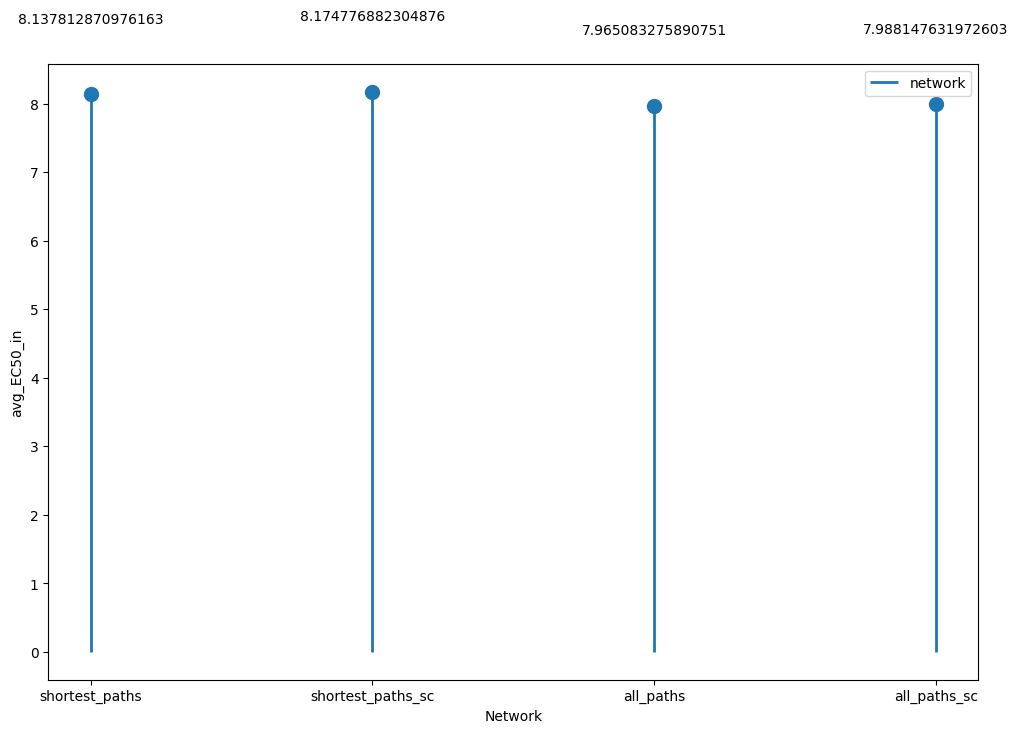

In [29]:
nc.visual.lollipop_plot(ec50_eval_results, 'network', 'avg_EC50_in')

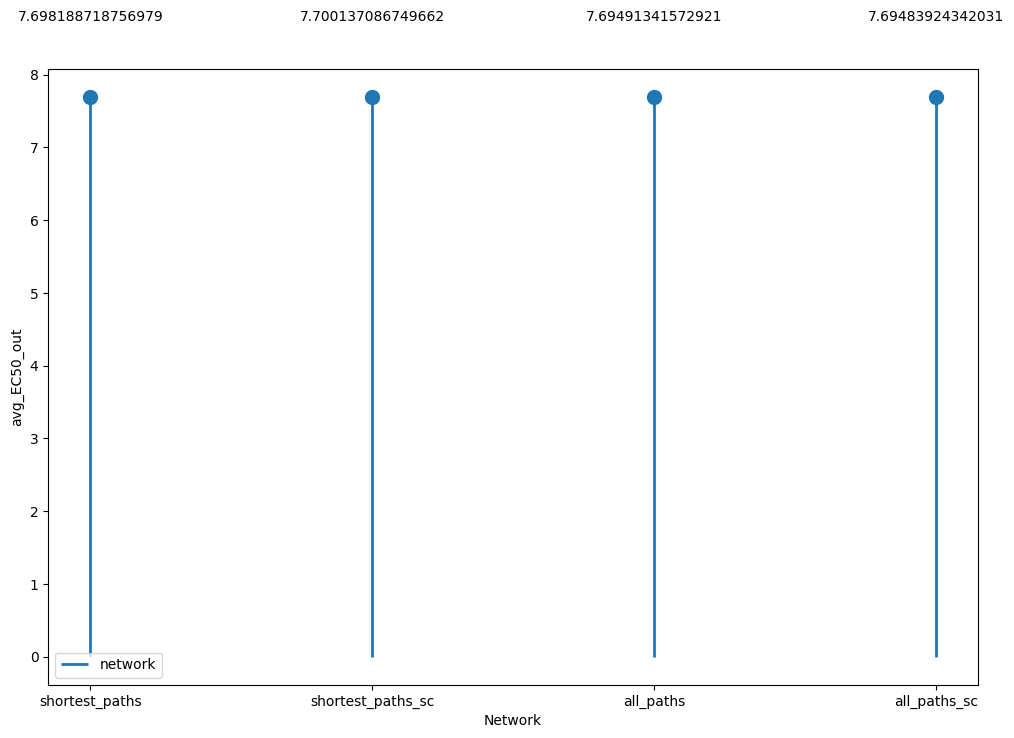

In [30]:
nc.visual.lollipop_plot(ec50_eval_results, 'network', 'avg_EC50_out')

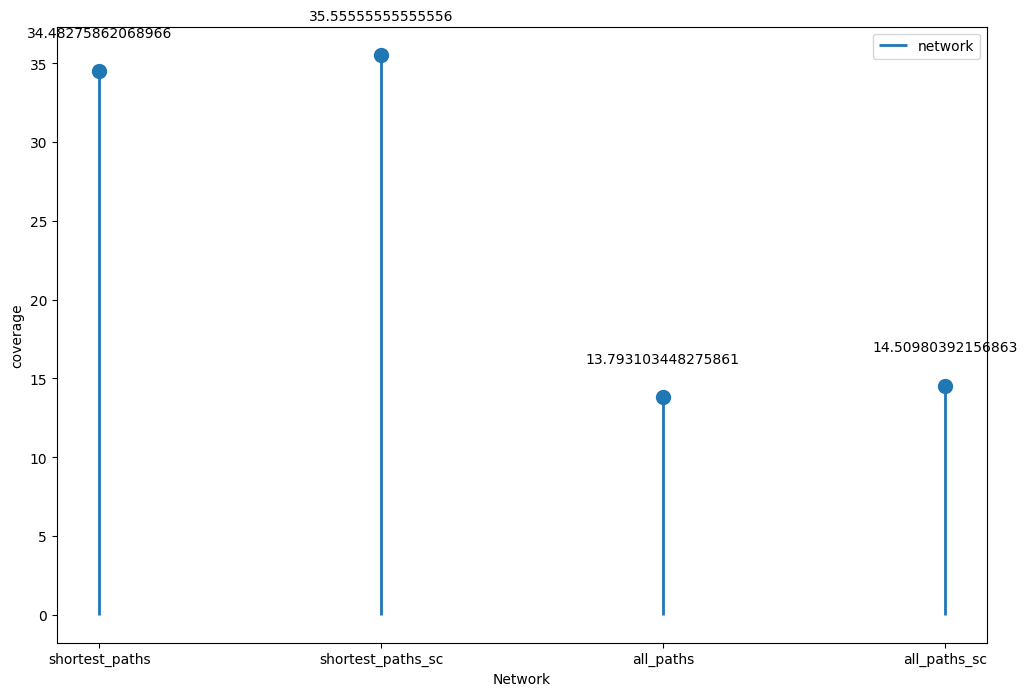

In [31]:
nc.visual.lollipop_plot(ec50_eval_results, 'network', 'coverage')

We would trust the shortest paths + sign consistency more, since it has the highest coverage and also highest pEC50 (highest sensitivity)

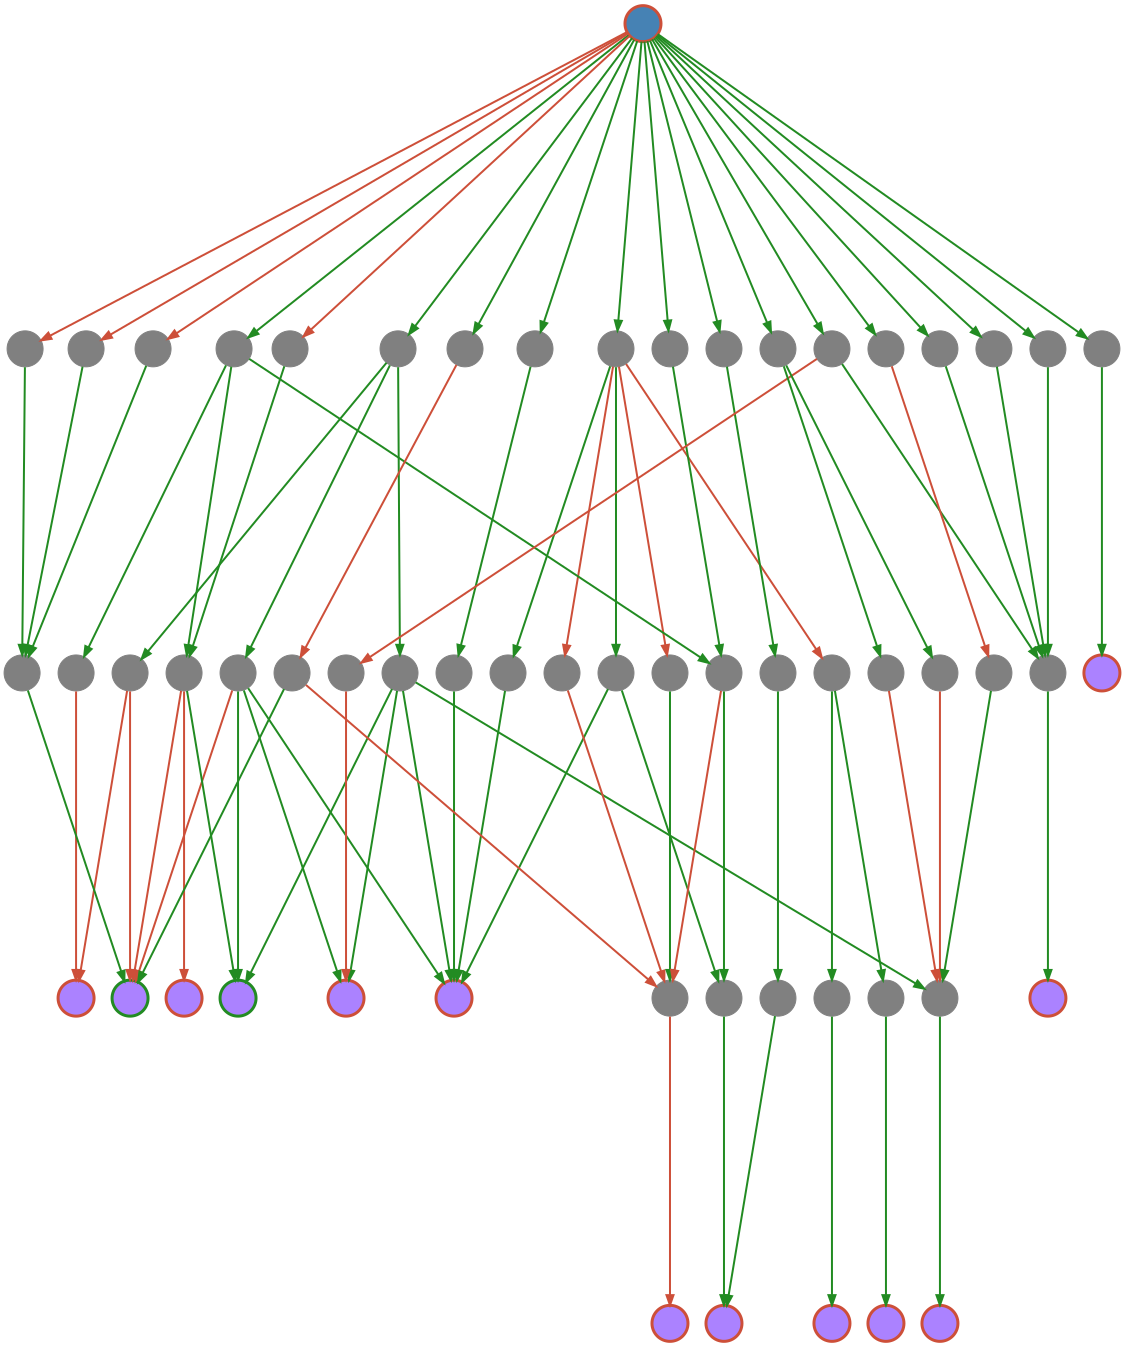

In [32]:
nc.visual.visualize_graph_simple(network_dict['shortest_paths'], source_dict, target_dict)